In [1]:
import pandas as pd
import numpy as np

# Data cleaning and preparation

We start by loading data from July to September 2022.

In [2]:
def load_data(month, days=31):
    full_df = pd.read_csv(f"./data/2022-{str(month)}-1.csv")
    for date in range(2, days+1):
        test_df = pd.read_csv(f'./data/2022-{str(month)}-{date}.csv')
        full_df = pd.concat([full_df, test_df])
    full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
    full_df = full_df.set_index('timestamp')
    return full_df

In [3]:
jul = load_data(7)
aug = load_data(8)
sep = load_data(9, days=30)
full_data = pd.concat([jul, aug, sep])
full_data.dropna(inplace=True)

In [4]:
full_data['available rate'] = full_data['lots_available'] / full_data['total_lots']
full_data.dropna(inplace=True)
grped_full = full_data.groupby(full_data.carpark_number)

For each carpark, we use the first 70% as training data and last 30% as testing data. We will use previous 8*24 hours availability as features to predict the next 24 hours availability.
We slice out the data for each carpark and resample them to fill in missing values. Then we prepare training and testing features and labels.

In [5]:
# helper method to create inputs and outputs from a given dataset
def prep_train_test(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)-24):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i:i+24].values)
        # if np.isnan(X[-1]).any():
        #     print(X[-1])
        # if np.isnan(Y[-1]).any():
        #     print(Y[-1])
    return X, Y

In [14]:
carparks = grped_full.carpark_number.unique()
trainX, trainY = [], []
testX, testY = [], []
feature_len = 24*8
split = 0.3
print("total ids:", len(carparks))
index = 0
for id in carparks:
    slice = grped_full.get_group(id[0])
    slice = slice.resample('1h').mean()
    if slice.shape[0] != 2208:
        print(slice.shape[0])
        print("Lossy data. Dropped")
        continue
    if slice.isnull().values.any():
        slice.fillna(method='ffill', inplace=True)
    split_index = int(slice.shape[0] * split)
    X_train1, Y_train1 = prep_train_test(slice[:split_index], feature_len)
    X_test1, Y_test1 = prep_train_test(slice[split_index:], feature_len)
    trainX.extend(X_train1)
    trainY.extend(Y_train1)
    testX.extend(X_test1)
    testY.extend(Y_test1)
    index += 1
    if index % 100 == 0:
        print(index, "done")
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)


total ids: 1965
855
Lossy data. Dropped
100 done
200 done
300 done
400 done
500 done
730
Lossy data. Dropped
730
Lossy data. Dropped
600 done
700 done
800 done
900 done
1000 done
1100 done
83
Lossy data. Dropped
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done


In [19]:
print("train test length:", trainX.shape, trainY.shape)
print("testing test length:", testX.shape, testY.shape)
print("input shape:", trainX[0].shape)
print("output shape:", trainY[0].shape)

train test length: (874606, 192) (874606, 24)
testing test length: (2608130, 192) (2608130, 24)
input shape: (192,)
output shape: (24,)


# Model 1: Multi-layer perceptron (MLP)

### In this section, we will use MLP model to predict the parking availability within the next 24 hours

In [133]:
# Import libraries
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot')


In [134]:
## Q2 data 
def prep_train_test_Q2(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i])
    X = np.array(X)
    Y = np.array(Y)
    print(X.shape, Y.shape)
    return X, Y

In [123]:
## Q2 data
rg_jul = pd.Series(pd.date_range(
    '7/1/2022', '8/1/2022', freq='1h', inclusive='left'))
rg_aug = pd.Series(pd.date_range(
    '8/1/2022', '9/1/2022', freq='1h', inclusive='left'))
jul = jul.resample('1h').mean()
jul['available rate'] = jul['lots_available'] / jul['total_lots']

aug = aug.resample('1h').mean()
aug['available rate'] = aug['lots_available'] / aug['total_lots']



/var/folders/_b/lkm0k5zn1cq5vrps1mrqwcb00000gn/T/ipykernel_82585/3714205907.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  jul = jul.resample('1h').mean()
/var/folders/_b/lkm0k5zn1cq5vrps1mrqwcb00000gn/T/ipykernel_82585/3714205907.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aug = aug.resample('1h').mean()


In [136]:
## Q3 data
print(trainX.dtype,trainY.dtype)
print(testX.dtype,testY.dtype)
print(np.isnan(trainX).any() ,np.isnan(trainY).any())
print(np.isnan(testX).any() ,np.isnan(testY).any())
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

float64 float64
float64 float64
False False
False False
(874606, 192) (874606, 24)
(2608130, 192) (2608130, 24)


In [137]:
## Q3 data for modelling, not working
model = MLPRegressor(activation='relu', hidden_layer_sizes=(50,),
             max_iter=1000, solver='adam')
model.fit(trainX,trainY)
print(model)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000)


#### MLP regressor

In [44]:
#Hyperparameter tuning
param = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}
model = MLPRegressor(max_iter = 1000)
gridsMLP = GridSearchCV(model,param)

gridsMLP.fit(X_train1,Y_train1)

print(gridsMLP.best_params_)
print(gridsMLP.best_estimator_)


{'activation': 'identity', 'alpha': 0.0005, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
MLPRegressor(activation='identity', alpha=0.0005, hidden_layer_sizes=(1,),
             max_iter=1000, solver='lbfgs')


In [45]:
model = MLPRegressor(activation='identity', hidden_layer_sizes=(50,),
             max_iter=1000, solver='lbfgs')
model.fit(X_train1,Y_train1)
print(model)

MLPRegressor(activation='identity', hidden_layer_sizes=(50,), max_iter=1000,
             solver='lbfgs')


In [138]:
Y_pred = model.predict(testX)

In [139]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [142]:
mlp_r2 = metrics.r2_score(testY, Y_pred)
mlp_rms = metrics.mean_squared_error(testY, Y_pred)
mlp_percentage_error = mean_absolute_percentage_error(testY, Y_pred)
print(f"Model's r2score: {mlp_r2},\nRMS: {mlp_rms},\nPercentage Error: {mlp_percentage_error*100} %")

Model's r2score: 0.9492725386470046,
RMS: 0.005455848256477322,
Percentage Error: 1477317506649597.0 %


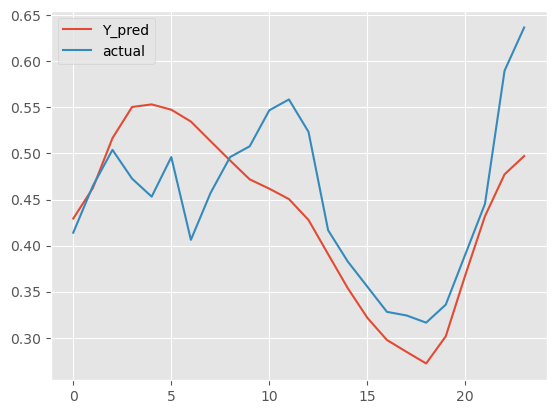

In [150]:
plt.plot(Y_pred[93], label='Y_pred')
plt.plot(testY[93], label='actual')
plt.legend()

Text(0, 0.5, 'Actual')

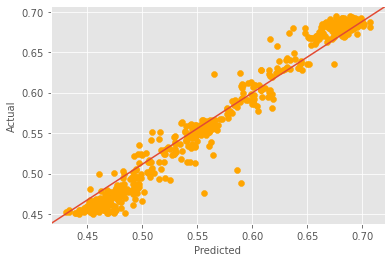

In [50]:
plt.scatter(Y_pred, Y_test1, label='Y_pred', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

# Model 2: Linear Regression

# Model 3: LSTM

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [21]:
# reshape input to be [samples, time steps, features]
trainX1 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX1 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX1.shape
print(testX1.shape)

(2608130, 1, 192)


In [44]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(192, input_shape=(1,192), activation="relu"))
model.add(Dense(24))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX1, trainY, epochs=20, batch_size=64, verbose=2)

Epoch 1/20
13666/13666 - 66s - loss: 0.0064 - 66s/epoch - 5ms/step
Epoch 2/20
13666/13666 - 60s - loss: 0.0049 - 60s/epoch - 4ms/step
Epoch 3/20
13666/13666 - 60s - loss: 0.0046 - 60s/epoch - 4ms/step
Epoch 4/20
13666/13666 - 60s - loss: 0.0045 - 60s/epoch - 4ms/step
Epoch 5/20
13666/13666 - 62s - loss: 0.0044 - 62s/epoch - 5ms/step
Epoch 6/20
13666/13666 - 60s - loss: 0.0043 - 60s/epoch - 4ms/step
Epoch 7/20
13666/13666 - 61s - loss: 0.0043 - 61s/epoch - 4ms/step
Epoch 8/20
13666/13666 - 62s - loss: 0.0042 - 62s/epoch - 5ms/step
Epoch 9/20
13666/13666 - 61s - loss: 0.0042 - 61s/epoch - 4ms/step
Epoch 10/20
13666/13666 - 60s - loss: 0.0041 - 60s/epoch - 4ms/step
Epoch 11/20
13666/13666 - 57s - loss: 0.0041 - 57s/epoch - 4ms/step
Epoch 12/20
13666/13666 - 66s - loss: 0.0041 - 66s/epoch - 5ms/step
Epoch 13/20
13666/13666 - 71s - loss: 0.0040 - 71s/epoch - 5ms/step
Epoch 14/20
13666/13666 - 67s - loss: 0.0040 - 67s/epoch - 5ms/step
Epoch 15/20
13666/13666 - 58s - loss: 0.0040 - 58s/epoch 

In [45]:
ypred_lstm = model.predict(testX1)

81505/81505 [==============================] - 242s 3ms/step


In [48]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
for i in range(24):
    print("Hour{}:       RMS is {}" .format(i,mean_squared_error(testY[:,i], ypred_lstm[:,i])) )
    print("        R2 Score is {}" .format(r2_score(testY[:,i], ypred_lstm[:,i])) )
    print("Percentage Error is {}" .format(i,mean_squared_error(testY[:,i], ypred_lstm[:,i])) )

Hour0:       RMS is 0.0021674755483789233
        R2 Score is 0.9798385884083395
Percentage Error is 0
Hour1:       RMS is 0.003101125757068376
        R2 Score is 0.9711529330870922
Percentage Error is 1
Hour2:       RMS is 0.0038544333649333565
        R2 Score is 0.9641460039678306
Percentage Error is 2
Hour3:       RMS is 0.004380686437999644
        R2 Score is 0.9592523327208364
Percentage Error is 3
Hour4:       RMS is 0.004695423711887654
        R2 Score is 0.9563271851737539
Percentage Error is 4
Hour5:       RMS is 0.005034638893905739
        R2 Score is 0.9531757803079965
Percentage Error is 5
Hour6:       RMS is 0.005330153534645749
        R2 Score is 0.9504317915706594
Percentage Error is 6
Hour7:       RMS is 0.005541553222119979
        R2 Score is 0.9484692361671754
Percentage Error is 7
Hour8:       RMS is 0.005793532818368991
        R2 Score is 0.9461261900410924
Percentage Error is 8
Hour9:       RMS is 0.005912901102771065
        R2 Score is 0.9450166476657846


# Overall Flow

Suppose we have saved the most recent 8 days data in csv files. We can use the following code to generate a condensed csv file for recent data. The data in the condensed csv file will be used for prediction. Code below shows how to generate the condensed csv file from recent 8 days data.

In [42]:
def generate_recent_csv():
    df = load_data(11, days=8)
    df['available rate'] = df['lots_available'] / df['total_lots']
    grped = df.groupby(df.carpark_number)
    carparks = grped.carpark_number.unique()
    carparks = [carpark[0] for carpark in carparks]
    new_df = pd.DataFrame(columns=carparks)
    for id in carparks:
        slice = grped.get_group(id)
        slice = slice.resample('1h').mean()
        if slice.shape[0] != 24*8:
            print("Lossy data. Dropped")
            print(id)
            continue
        new_df[id] = slice['available rate'].values
    new_df.index = slice.index
    new_df.to_csv("./data/recent.csv")

generate_recent_csv()

Lossy data. Dropped
Y49H


In [14]:
from queue import PriorityQueue

def find_nearest_x(x, y, location_dict):
    shortest = PriorityQueue()
    for key, loc in location_dict.items():
        dist = (loc[0] - x)**2 + (loc[1] - y)**2
        shortest.put((-dist, key))
        if shortest.qsize() > 5:
            shortest.get()
    res = [shortest.get()[1] for i in range(5)]
    res.reverse()
    return res

def create_location_dict(loc_info: pd.DataFrame):
    location_dict = {}
    for row in loc_info.iterrows():
        content = row[1]
        name = content[0]
        location = (content[2], content[3])
        location_dict[name] = location
    return location_dict

def model_predict(input):
    return input[-24:].values

In [15]:
loc_info = pd.read_csv("./data/hdb-carpark-information.csv")
recent = pd.read_csv("./data/recent.csv")
carpark_info = create_location_dict(loc_info)
top5 = find_nearest_x(30314.7936, 31490.4942, carpark_info)
for id in top5:
    if id not in recent.columns:
        print(f"one of the nearest carpark {id} is not in the recent data")
        continue
    col = recent[id][-24*8:]
    prediction = model_predict(col)
    print(f"carpark {id} prediction: {prediction}")


carpark ACB prediction: [0.64516129 0.64516129 0.64516129 0.55913978 0.5483871  0.52688172
 0.43010753 0.05376344 0.08602151 0.         0.01075269 0.07526882
 0.02150538 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.05376344 0.05376344        nan 0.03225806 0.03225806]
carpark CY prediction: [0.35483871 0.35483871 0.35483871 0.16129032 0.09677419 0.16129032
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.                nan 0.         0.        ]
carpark WCB prediction: [0.37062937 0.42657343 0.40559441 0.3986014  0.39160839 0.37762238
 0.37762238 0.29370629 0.3006993  0.13986014 0.00699301 0.00699301
 0.00699301 0.00699301 0.         0.         0.         0.
 0.         0.00699301 0.00699301        nan 0.00699301 0.00699301]
one of the nearest carpark SR2 is not in the recent data
one of the nearest carpark SR1 is not in the recent data
